In [1]:
import pandas as pd
from pathlib import Path

pd.set_option('display.width', 1000)

In [2]:
# online banking transaction data
path = Path('./data/Fraud Detection with Natural Language Processing.pkl')
df_data = pd.read_pickle(path)

In [3]:
# remove rows with invalid time values
df_data = df_data[df_data.times.apply(lambda x: x[-1]=="]")]

In [4]:
# print 1st 10 rows of data to get an idea what it looks like
print(df_data.head(10))

# use .shape to get row count
num_rows = df_data.shape[0]
print(f"\nNumber of rows: {num_rows}")

                                              actions                                              times  execution_time  Amount  device_freq   ip_freq  beneficiary_freq  application_freq  is_fraud
1   [[22], [27], [24], [1], [1268], [1269], [1267]...  [0, 33204.0, 215636.0, 443415.0, 72586.0, 3424...             203      13     1.000000  1.000000          0.500000               1.0         0
2   [[22], [24], [27], [1], [1268], [1269], [1267]...  [0, 25459.0, 46236.0, 428626.0, 42785.0, 74158...             359     310     1.000000  0.333333          0.333333               1.0         0
3   [[22], [1], [29], [22], [26], [2], [23], [25],...  [0, 440927.0, 5785.0, 46875.0, 968650.0, 31175...             250     350     1.000000  0.500000          0.500000               1.0         0
4   [[22], [24], [27], [72], [1269], [1268], [1267...  [0, 93894.0, 46810.0, 548388.0, 132548.0, 3784...             203     350     1.000000  0.600000          0.400000               1.0         0
5   [[22],

In [5]:
# use built in .info() method to show column data types and non-null count
df_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 105302 entries, 1 to 105302
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   actions           105302 non-null  object 
 1   times             105302 non-null  object 
 2   execution_time    105302 non-null  int64  
 3   Amount            105302 non-null  int32  
 4   device_freq       105302 non-null  float64
 5   ip_freq           105302 non-null  float64
 6   beneficiary_freq  105302 non-null  float64
 7   application_freq  105302 non-null  float64
 8   is_fraud          105302 non-null  int64  
dtypes: float64(4), int32(1), int64(2), object(2)
memory usage: 7.6+ MB


In [6]:
with pd.option_context('display.float_format', '  {:.1f}'.format, 'display.width', 100):
    print(df_data.describe().T)

                      count    mean      std    min     25%     50%     75%         max
execution_time     105302.0   655.7   1367.9   15.0   359.0   623.0   795.0    127578.0
Amount             105302.0   468.8   7096.0    0.0    37.0   100.0   240.0   1500000.0
device_freq        105302.0     0.7      0.3    0.0     0.4     0.9     1.0         1.0
ip_freq            105302.0     0.3      0.3    0.0     0.0     0.1     0.3         1.0
beneficiary_freq   105302.0     0.4      0.3    0.0     0.1     0.3     0.6         1.0
application_freq   105302.0     0.9      0.2    0.0     0.9     1.0     1.0         1.0
is_fraud           105302.0     0.0      0.0    0.0     0.0     0.0     0.0         1.0


In [7]:
# show bin counts for 'is_fraud'
class_counts = df_data['is_fraud'].value_counts()
print(class_counts)

is_fraud
0    105201
1       101
Name: count, dtype: int64


In [8]:
# vocabulary of API calls
path_vocab = Path('./data/vocab.csv')
df_vocab = pd.read_csv(path_vocab)

In [9]:
# print 1st 10 rows of data to get an idea what it looks like
print(df_vocab.head(20))

# use .shape to get row count
num_rows = df_vocab.shape[0]
print(f"\nNumber of rows: {num_rows}")

                                       Name
0          /ACCOUNTS/ACCOUNTS_FULL_EXCHANGE
1                      /PROFILE/USERPROFILE
2                /P2PREGISTRATION/ASKMEMBER
3                         /CARDS/FETCHCARDS
4                   /ACCOUNTS/ACCOUNTS_FULL
5                    /CAMPAIGN/GETCAMPAIGNS
6                           /TEMPLATES/META
7                 /TRANSACTIONS/SERIES/POST
8             /USERROLE/GETAPPLICATIONROLES
9                  /API/CAMPAIGN/GETBALANCE
10  /P2PMEMBER/GETP2PMEMBERIDBYACTUALUSERID
11                            /ACCOUNTS/GET
12                          /CATEGORIES/GET
13        /MASSPAYMENTS/DEFERREDMASSNOFILES
14                              /LOANS/LIST
15                          /WEALTH/PARTYID
16           /TIMEDEPOSITS/DETAILEDACCOUNTS
17                /AUTHENTICATION/FASTLOGIN
18           /API/FASTLOGIN/EXPIRATIONQUERY
19                           /ACCOUNT/LOGIN

Number of rows: 1916


In [10]:
#%pip install wordninja

In [11]:
import re
import wordninja

def transform_name(name):

    # change to lower case
    name = name[1:].lower()
    name = name.replace('userid',' user id ')
    name = name.replace('smsotp',' sms otp ')

    # replace '/' and '_' with spaces
    name = re.sub(r'[/]', ' and ', name)
    name = re.sub(r'[_]', ' ', name)
    
    # Split compound words using wordninja
    parts = wordninja.split(name)
    
    # Join the parts with a space and convert to lowercase
    name = ' '.join(parts).strip().lower()

    # fix some of the words split up by wordninja
    name = re.sub(r'\bv\b', 'version', name)
    name = re.sub(r'\bp\s2\sp\b', 'peer', name)
    name = re.sub(r'\bot\sp\b', 'otp', name)
    name = re.sub(r'\bp\s2\sb\b', 'business', name)
    name = re.sub(r'\bs\ssf\b', 'ssf', name)
    name = re.sub(r'\bp\sfm\b', 'pay from', name)
    name = re.sub(r'\bi\sban\staxi\sd\b', 'iban tax id', name)
    name = re.sub(r'\bi\sban\sbic\b', 'iban bic', name)
    
    # put payment abbreviation types back together
    match = re.search(r'api(.*?)payment', name)
    if match:
        match = re.sub(r'\s+', '', match.group(1).strip())
        name = f"api {match} payment"

    # Format the final string
    # return f"{name} [SEP]"
    return f"{name} ."

In [12]:
# transform the vocabulary 
df_vocab['new_name'] = df_vocab['Name'].apply(transform_name)

# print 1st 10 rows of data to get an idea what it looks like
print(df_vocab.head(20))

# use .shape to get row count
num_rows = df_vocab.shape[0]
print(f"\nNumber of rows: {num_rows}")

                                       Name                                           new_name
0          /ACCOUNTS/ACCOUNTS_FULL_EXCHANGE              accounts and accounts full exchange .
1                      /PROFILE/USERPROFILE                         profile and user profile .
2                /P2PREGISTRATION/ASKMEMBER                 peer registration and ask member .
3                         /CARDS/FETCHCARDS                            cards and fetch cards .
4                   /ACCOUNTS/ACCOUNTS_FULL                       accounts and accounts full .
5                    /CAMPAIGN/GETCAMPAIGNS                       campaign and get campaigns .
6                           /TEMPLATES/META                               templates and meta .
7                 /TRANSACTIONS/SERIES/POST                 transactions and series and post .
8             /USERROLE/GETAPPLICATIONROLES              user role and get application roles .
9                  /API/CAMPAIGN/GETBALANCE       

In [13]:
# helper script to find short words
unique_short_words = set()
name_dict = {}

for index, row in df_vocab.iterrows():
    name = row['new_name']
    words = name.split()
    for word in words:
        if len(word) < 4:
            unique_short_words.add(word)
            if word not in name_dict:
                name_dict[word] = []
            name_dict[word].append(name)

print("Unique short words:", unique_short_words)
print("Original names by short word:")
for word, names in name_dict.items():
    print(f"{word}: {names}")

Unique short words: {'us', 'b', 'add', 'ky', 'maz', 'app', 'ib', 'mod', 'doc', 'ds', 'can', 'co', 'hdi', 'row', 'pm', 'pro', 'mt', 'eu', 'fp', 'vol', 'st', 'a', 'and', 'pos', '2', 'sms', 'ask', 'ext', 'ssf', 'ent', 'de', 'ott', 'geo', 'or', 'no', 'pp', 'api', 'my', 'p', 'for', 'ui', 'erp', 'faq', 'ro', 'db', 'pre', 'ids', 'eps', 'set', 'zip', '.', 'pi', 'ms', 's', '0', 'c', 'po', 'not', 'if', 'web', 'car', 'gp', 'it', 'up', 'xml', 'cc', 'is', 'put', 'mi', 'buy', 'ban', 'rf', '4', 'new', 'bic', 'gr', 'i', 'un', 'of', 'rib', 'net', 'id', 'pdf', 'os', 'ex', 'isp', 'top', 'dom', 'in', '3', 'e', 'log', 'www', 'get', 'd', 'by', 'fid', 'imp', 'pay', '1', 'iv', 'on', 'pin', 'trn', 'rts', 'gia', 'sco', 'aps', 'old', 'ppl', 'ka', 'own', 'mer', 'ep', 'ard', 'cp', 'max', 'atm', 'o', 'to', 'er', 'r', 'otp', 'te', 'tho', 'all', 'tax', 'mk', 'nt', 't', 'org', 'nf', 'gdp', 'fb', 'sue'}
Original names by short word:
and: ['accounts and accounts full exchange .', 'profile and user profile .', 'peer regi

In [14]:
#build the raw text, using the names and the (index-inverted) tokens 
action_names = df_vocab.new_name.to_list()
id_to_action = {str(i):a for i,a in enumerate(action_names)}
action_to_id = {a:str(i) for i,a in enumerate(action_names)}

In [15]:
import numpy as np
from ast import literal_eval

df = df_data.copy(deep=True)

# Recall to cast the strings into lists
df.actions = df.actions.apply(literal_eval)

df["times"] = df.times.apply(literal_eval).apply(lambda x: [i/1000 for i in x])
df["Action time mean"] = df.times.apply(np.mean)
df["Action time std"] = df.times.apply(np.std)
df["log(amount)"] = df.Amount.apply(np.log)
df["Transaction Type"] = df.is_fraud.apply(lambda x: "Fraud" if x else "Non Fraud")
df["time_to_first_action"] = df.times.apply(lambda x: x[1] if len(x)>1 else 0)
df["actions_str"] = df.actions.apply(lambda x: " ".join([id_to_action[str(i[0])] for i in x if len(i)>0]))
df["total_time_to_transaction"] = df.times.apply(sum)/1000
df['actions'] = df['actions'].apply(lambda x: [item for sublist in x for item in sublist])
df.head(2)

,actions,times,execution_time,Amount,device_freq,ip_freq,beneficiary_freq,application_freq,is_fraud,Action time mean,Action time std,log(amount),Transaction Type,time_to_first_action,actions_str,total_time_to_transaction
1,"[22, 27, 24, 1, 1268, 1269, 1267, 22, 29, 1, 2...","[0.0, 33.204, 215.636, 443.415, 72.586, 34.241...",203,13,1.0,1.000000,0.500000,1.0,0,177.859292,218.368580,2.564949,Non Fraud,33.204,profile and get customer response . tax free a...,4.268623
2,"[22, 24, 27, 1, 1268, 1269, 1267, 2, 23, 6, 25...","[0.0, 25.459, 46.236, 428.626, 42.785, 74.158,...",359,310,1.0,0.333333,0.333333,1.0,0,196.875569,252.496316,5.736572,Non Fraud,25.459,profile and get customer response . campaign a...,587.279823


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def word_count(text):
    return len(str(text).split())

def plot_word_count_histogram(df, bins=50, col='actions_str'):
    # Calculate word counts
    df['word_count'] = df[col].apply(word_count)
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    
    # Plot histograms for fraud and non-fraud
    sns.histplot(data=df[df['is_fraud'] == 0], x='word_count', bins=bins, 
                 kde=False, stat='percent', alpha=0.5, label='Non-Fraud')
    sns.histplot(data=df[df['is_fraud'] == 1], x='word_count', bins=bins, 
                 kde=False, stat='percent', alpha=0.5, label='Fraud')

    plt.title('Distribution of Word Counts in actions_str by Fraud Status')
    plt.xlabel('Word Count')
    plt.ylabel('Density')
    plt.legend()

    # Add text with mean and median values
    for fraud in [0, 1]:
        subset = df[df['is_fraud'] == fraud]
        mean = subset['word_count'].mean()
        median = subset['word_count'].median()
        label = 'Fraud' if fraud else 'Non-Fraud'
        plt.text(0.7, 0.95 - fraud*0.1, f'{label} Mean: {mean:.2f}, Median: {median:.2f}', 
                 transform=plt.gca().transAxes, fontsize=10)

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print(df.groupby('is_fraud')['word_count'].describe())



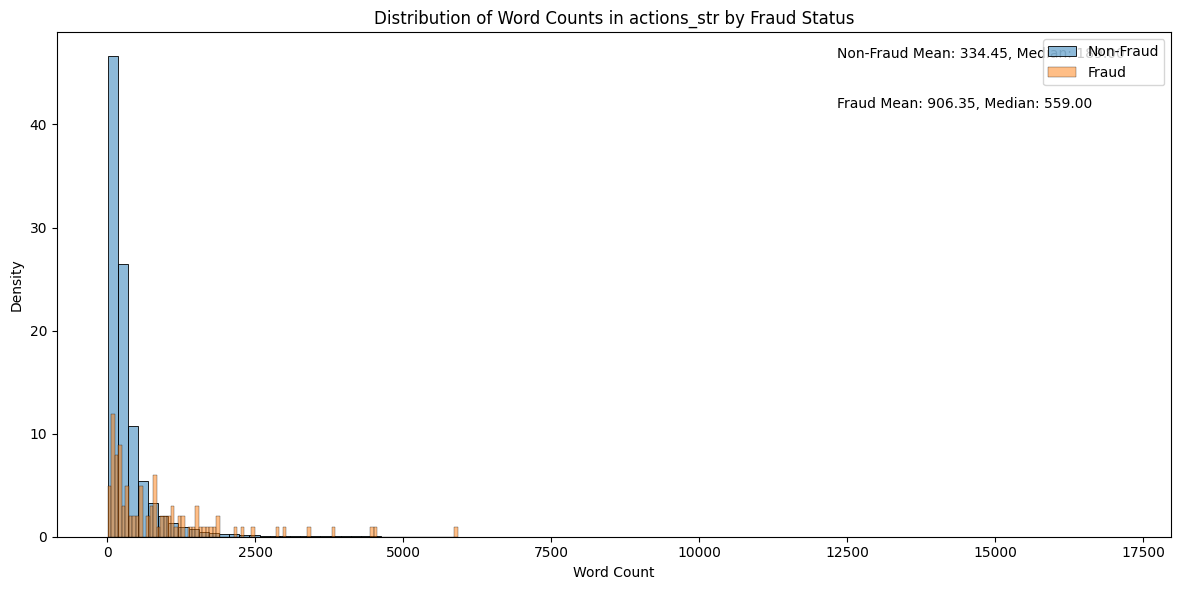

             count        mean          std  min    25%    50%     75%      max
is_fraud                                                                       
0         105201.0  334.449682   524.096684  4.0   84.0  189.0   369.0  17121.0
1            101.0  906.346535  1061.882992  6.0  186.0  559.0  1233.0   5925.0


In [17]:
plot_word_count_histogram(df,100)

[nltk_data] Downloading package stopwords to /home/glw/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


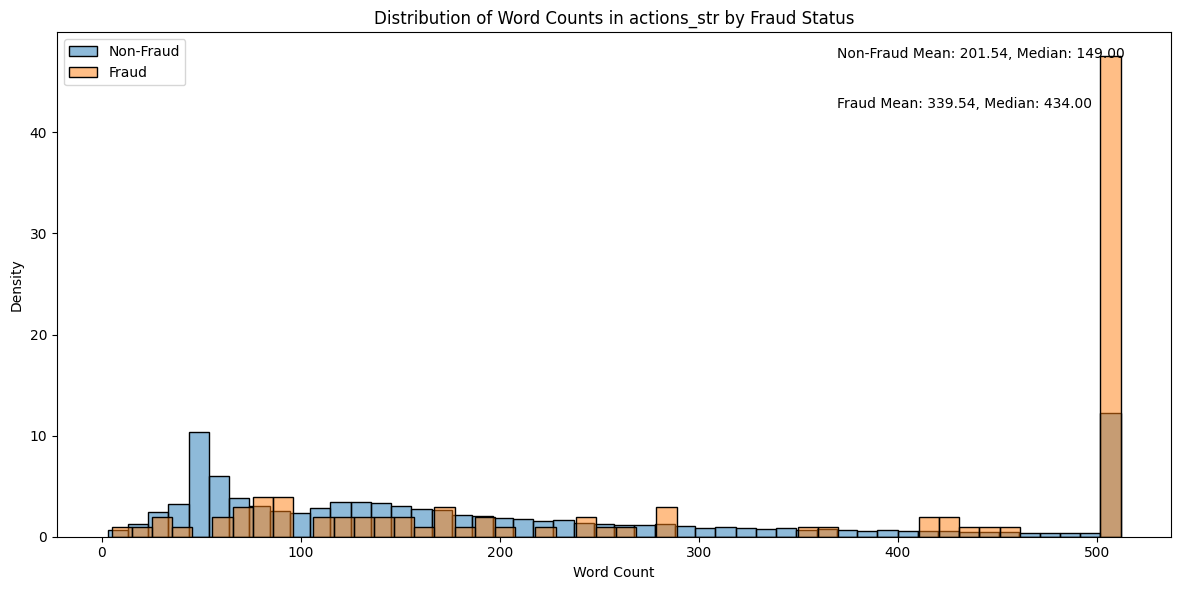

             count        mean         std  min    25%    50%    75%    max
is_fraud                                                                   
0         105201.0  201.536563  158.398756  3.0   66.0  149.0  292.0  512.0
1            101.0  339.544554  188.773702  5.0  143.0  434.0  512.0  512.0


In [18]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def remove_stopwords_and_splice(text):
    temp = ' '.join([word for word in text.split() if word.lower() not in stop_words])
    tokens = temp.split()
    if len(tokens) <= 256 * 2:
        return ' '.join(tokens)
    return ' '.join(tokens[:256] + tokens[-256:])

df['no_stopwords'] = df['actions_str'].apply(remove_stopwords_and_splice)
plot_word_count_histogram(df,50,'no_stopwords')

In [19]:
# use built in .info() method to show column data types and non-null count
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 105302 entries, 1 to 105302
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   actions                    105302 non-null  object 
 1   times                      105302 non-null  object 
 2   execution_time             105302 non-null  int64  
 3   Amount                     105302 non-null  int32  
 4   device_freq                105302 non-null  float64
 5   ip_freq                    105302 non-null  float64
 6   beneficiary_freq           105302 non-null  float64
 7   application_freq           105302 non-null  float64
 8   is_fraud                   105302 non-null  int64  
 9   Action time mean           105302 non-null  float64
 10  Action time std            105302 non-null  float64
 11  log(amount)                105302 non-null  float64
 12  Transaction Type           105302 non-null  object 
 13  time_to_first_action       105302 

In [20]:
import pytorch_lightning as pl
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.model_selection import train_test_split

import torch
from torchmetrics.classification import Accuracy
from torch.utils.data import TensorDataset, DataLoader


device = "cuda" if torch.cuda.is_available() else "cpu"


/home/glw/AI_574_project/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [49]:
import pandas as pd
import numpy as np

# Separate fraud and non-fraud cases
fraud_df = df[df['is_fraud'] == 1]
fraud_df = pd.concat([fraud_df, fraud_df])
non_fraud_df = df[df['is_fraud'] == 0]

# Determine the number of non-fraud cases to sample
fraud_count = len(fraud_df)
non_fraud_sample_count = min(len(non_fraud_df), fraud_count * 9)

# Randomly sample non-fraud cases
non_fraud_sample = non_fraud_df.sample(n=non_fraud_sample_count, random_state=42)

# Combine fraud cases with sampled non-fraud cases
train_df_slice = pd.concat([fraud_df, non_fraud_sample])

# Shuffle the combined DataFrame
train_df_slice = train_df_slice.sample(frac=1, random_state=42).reset_index(drop=True)
# train_df_slice = df.head(3000)

print(f"Total samples in train_df_slice: {len(train_df_slice)}")
print(f"Fraud cases: {len(train_df_slice[train_df_slice['is_fraud'] == 1])}")
print(f"Non-fraud cases: {len(train_df_slice[train_df_slice['is_fraud'] == 0])}")

Total samples in train_df_slice: 2020
Fraud cases: 202
Non-fraud cases: 1818


In [64]:
class FraudClassifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model_name = 'distilbert-base-uncased'
        self.accuracy = Accuracy(task="multiclass", num_classes=2)
        self.model = AutoModelForSequenceClassification.from_pretrained(self.model_name, num_labels=2, output_attentions=False, output_hidden_states=False)
        self.class_weights = torch.tensor([1.0,1.0])
        self.loss = torch.nn.CrossEntropyLoss(weight=self.class_weights)

    def prepare_data(self):
        tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        encoded_data = tokenizer(train_df_slice['no_stopwords'].tolist(), padding=True, truncation=True, return_tensors="pt")

        input_ids = encoded_data['input_ids']
        attention_mask = encoded_data['attention_mask']
        labels = torch.tensor(train_df_slice['is_fraud'].values)
        
        train_inputs, val_inputs, train_masks, val_masks, train_labels, val_labels = \
            train_test_split(input_ids, attention_mask, labels, test_size=0.2, random_state=42)

        self.train_data = TensorDataset(train_inputs, train_masks, train_labels)
        self.val_data = TensorDataset(val_inputs, val_masks, val_labels)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.logits
    
    def training_step(self, batch, batch_idx):
        input_ids, attention_mask, labels = batch
        logits = self(input_ids, attention_mask)
        loss = self.loss(logits, labels)
        
        preds = torch.argmax(logits, dim=1)
        accuracy = self.accuracy(preds, labels)
        
        self.log('train_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        self.log('train_accuracy', accuracy, prog_bar=True, on_step=True, on_epoch=True)
        
        return {'loss': loss, 'log': {'val_loss': loss}}
    
    def validation_step(self, batch, batch_idx):
        input_ids, attention_mask, labels = batch
        logits = self(input_ids, attention_mask)
        loss = self.loss(logits, labels)
        
        preds = torch.argmax(logits, dim=1)
        accuracy = self.accuracy(preds, labels)

        self.log('val_loss', loss, on_step=True, on_epoch=True)
        self.log('val_accuracy', accuracy, on_step=True, on_epoch=True)

        return {'val_loss': loss, 'val_accuracy': accuracy}
    
    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=32, shuffle=True, drop_last=True)

    def val_dataloader(self):
        return DataLoader(self.val_data, batch_size=32, shuffle=False, drop_last=False)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=2e-5)
    

In [65]:
class EpochLogger(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        epoch = trainer.current_epoch
        print(f"Epoch {epoch}\n{metrics}\n")

In [66]:
model = FraudClassifier()
trainer = pl.Trainer(default_root_dir='logs', max_epochs=10, log_every_n_steps=10, callbacks=[EpochLogger()])
trainer.fit(model)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                                | Params | Mode 
-------------------------------------------------------------------------
0 | accuracy | MulticlassAccuracy                  | 0      | train
1 | model    | DistilBertForSequenceClassification | 67.0 M | eval 
2 | loss     | CrossEntropyLoss                    | 0      | train
---------

Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 10.66it/s]

/home/glw/AI_574_project/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


/home/glw/AI_574_project/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 50/50 [00:15<00:00,  3.17it/s, v_num=6, train_loss_step=0.388, train_accuracy_step=0.844]Epoch 0
{'train_loss': tensor(0.3288, device='cuda:0'), 'train_loss_step': tensor(0.3878, device='cuda:0'), 'train_accuracy': tensor(0.9031, device='cuda:0'), 'train_accuracy_step': tensor(0.8438, device='cuda:0'), 'val_loss': tensor(0.3149, device='cuda:0'), 'val_loss_epoch': tensor(0.3149, device='cuda:0'), 'val_accuracy': tensor(0.8861, device='cuda:0'), 'val_accuracy_epoch': tensor(0.8861, device='cuda:0'), 'train_loss_epoch': tensor(0.3288, device='cuda:0'), 'train_accuracy_epoch': tensor(0.9031, device='cuda:0')}

Epoch 1: 100%|██████████| 50/50 [00:15<00:00,  3.16it/s, v_num=6, train_loss_step=0.298, train_accuracy_step=0.875, train_loss_epoch=0.329, train_accuracy_epoch=0.903] Epoch 1
{'train_loss': tensor(0.2241, device='cuda:0'), 'train_loss_step': tensor(0.2980, device='cuda:0'), 'train_accuracy': tensor(0.9087, device='cuda:0'), 'train_accuracy_step': tensor(0.

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 50/50 [00:17<00:00,  2.93it/s, v_num=6, train_loss_step=0.00109, train_accuracy_step=1.000, train_loss_epoch=0.00887, train_accuracy_epoch=0.999]


In [67]:
def get_predictions(model, dataloader, device):
    model.to(device)
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask)
            
            # Check if outputs is a tensor (logits) or an object with a logits attribute
            if isinstance(outputs, torch.Tensor):
                logits = outputs
            else:
                logits = outputs.logits
            
            preds = torch.argmax(logits, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels)

In [68]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.show()

In [69]:
model.eval()
y_pred, y_true = get_predictions(model, model.val_dataloader(), device)

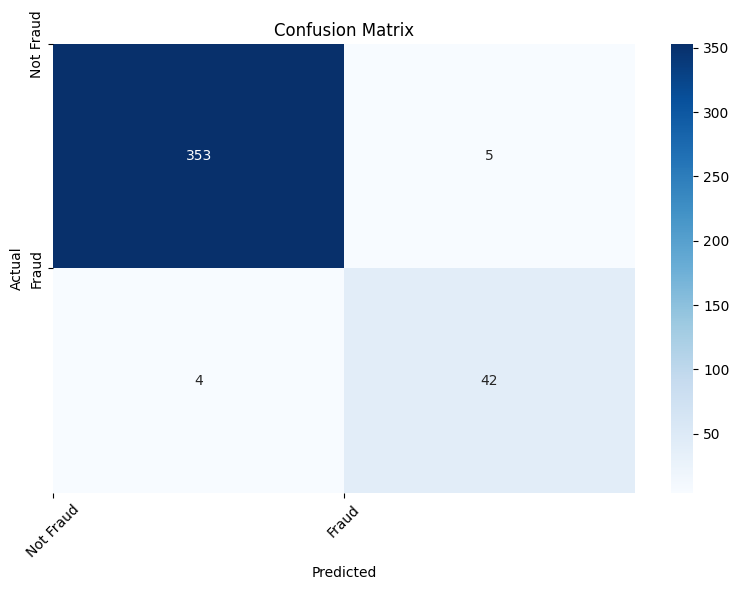

Accuracy: 0.9777
Precision: 0.8936
Recall: 0.9130
F1-score: 0.9032


In [70]:
# Plot confusion matrix
classes = ['Not Fraud', 'Fraud']
plot_confusion_matrix(y_true, y_pred, classes)

# Calculate and print metrics
print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"F1-score: {f1_score(y_true, y_pred):.4f}")

In [ ]:
# df_sample = df.sample(n=10000, random_state=42)
# texts = df_sample['actions_str'].tolist()
texts = df['actions_str'].tolist()

In [ ]:
# %pip install sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer

def batch_embed(texts, batch_size=32):
    model = SentenceTransformer('distilbert-base-nli-mean-tokens')
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        embeddings.extend(model.encode(batch))
    return np.array(embeddings)

embeddings = batch_embed(texts)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

def run_kmeans_and_plot(embeddings, cluster_range):
    # Reduce dimensionality for visualization
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)

    # Set up the plot
    n_plots = len(cluster_range)
    fig, axes = plt.subplots(2, (n_plots + 1) // 2, figsize=(20, 10))
    axes = axes.flatten()

    for i, n_clusters in enumerate(cluster_range):
        # Run K-means
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(embeddings)

        # Plot
        scatter = axes[i].scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], 
                                  c=cluster_labels, cmap='viridis', alpha=0.7)
        axes[i].set_title(f'K-means with {n_clusters} clusters')
        
        # Add colorbar
        plt.colorbar(scatter, ax=axes[i])

    # Remove any unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Define the range of cluster numbers to try
cluster_range = [2, 3, 4, 5, 6, 8, 10, 11]

# Run K-means with different numbers of clusters and plot
run_kmeans_and_plot(embeddings, cluster_range)

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split
from torchmetrics import Accuracy, F1Score, Precision, Recall

class FraudClassifier2(pl.LightningModule):
    def __init__(self, model_name='distilbert-base-uncased', learning_rate=2e-5, batch_size=64, dropout_rate=0.3):
        super().__init__()
        self.model_name = model_name
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.dropout_rate = dropout_rate
        self.accuracy = Accuracy(task="multiclass", num_classes=2)
        self.f1 = F1Score(task="multiclass", num_classes=2)
        self.precision = Precision(task="multiclass", num_classes=2)
        self.recall = Recall(task="multiclass", num_classes=2)
        self.model = AutoModelForSequenceClassification.from_pretrained(self.model_name, num_labels=2)
        self.loss = torch.nn.CrossEntropyLoss()

    def prepare_data(self):
        tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        train_df_slice = df.head(3000)
        # train_df_slice = df.sample(n=3000, random_state=42)
        encoded_data = tokenizer(train_df_slice['actions_str'].tolist(), padding=True, truncation=True, return_tensors="pt")

        input_ids = encoded_data['input_ids']
        attention_mask = encoded_data['attention_mask']
        labels = torch.tensor(train_df_slice['is_fraud'].values)
        
        train_inputs, val_inputs, train_masks, val_masks, train_labels, val_labels = \
            train_test_split(input_ids, attention_mask, labels, test_size=0.2, random_state=42)

        self.train_data = TensorDataset(train_inputs, train_masks, train_labels)
        self.val_data = TensorDataset(val_inputs, val_masks, val_labels)
        
    def forward(self, input_ids, attention_mask):
        return self.model(input_ids=input_ids, attention_mask=attention_mask).logits
    
    def training_step(self, batch, batch_idx):
        input_ids, attention_mask, labels = batch
        logits = self(input_ids, attention_mask)
        loss = self.loss(logits, labels)
        
        preds = torch.argmax(logits, dim=1)
        accuracy = self.accuracy(preds, labels)
        f1 = self.f1(preds, labels)
        
        self.log('train_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        self.log('train_accuracy', accuracy, prog_bar=True, on_step=True, on_epoch=True)
        self.log('train_f1', f1, prog_bar=True, on_step=True, on_epoch=True)
        
        return {'loss': loss, 'log': {'train_loss': loss}}
    
    def validation_step(self, batch, batch_idx):
        input_ids, attention_mask, labels = batch
        logits = self(input_ids, attention_mask)
        loss = self.loss(logits, labels)
        
        preds = torch.argmax(logits, dim=1)
        accuracy = self.accuracy(preds, labels)
        f1 = self.f1(preds, labels)
        precision = self.precision(preds, labels)
        recall = self.recall(preds, labels)

        self.log('val_loss', loss, on_step=True, on_epoch=True)
        self.log('val_accuracy', accuracy, on_step=True, on_epoch=True)
        self.log('val_f1', f1, on_step=True, on_epoch=True)
        self.log('val_precision', precision, on_step=True, on_epoch=True)
        self.log('val_recall', recall, on_step=True, on_epoch=True)

        return {'val_loss': loss, 'val_accuracy': accuracy}
    
    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_data, batch_size=self.batch_size, shuffle=False)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
            },
        }

In [ ]:
model2 = FraudClassifier2()
trainer2 = pl.Trainer(default_root_dir='logs', max_epochs=5, log_every_n_steps=10, callbacks=[EpochLogger()])
trainer2.fit(model2)

In [ ]:
model.eval()

# List of texts to predict
texts = [
    "profile and get customer response . api and accounts and generic transfer ."
]

# Tokenize the texts
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
encodings = tokenizer(texts, truncation=True, padding=True, return_tensors="pt")

# Move tensors to the same device as the model
input_ids = encodings['input_ids'].to(model.device)
attention_mask = encodings['attention_mask'].to(model.device)

# Get predictions
with torch.no_grad():
    logits = model(input_ids, attention_mask)
    predictions = torch.argmax(logits, dim=1)

# Convert predictions to CPU and then to a list
predictions = predictions.cpu().tolist()

In [ ]:
label_map = {
    0: "no fraud",
    1: "fraud"
}

for text, pred in zip(texts, predictions):
    print(f"Text: {text}")
    print(f"Prediction: {label_map[pred]}")
    print("-" * 50)